In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA

%matplotlib inline

df = pd.read_csv('data/data.csv')

X = df[[c for c in df.keys()][1:]].values
y = df['CLASS'].values

kf = KFold(n_splits=10, random_state=0, shuffle=True)
kf.get_n_splits(X)

10

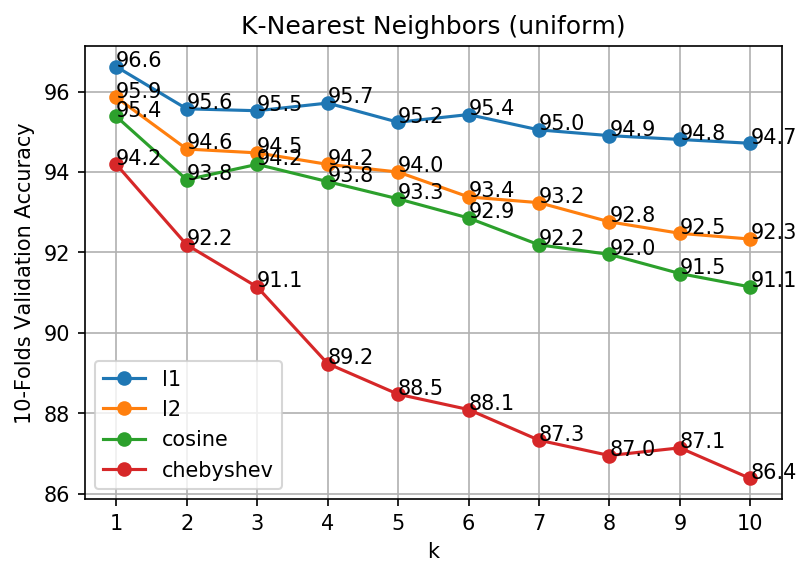

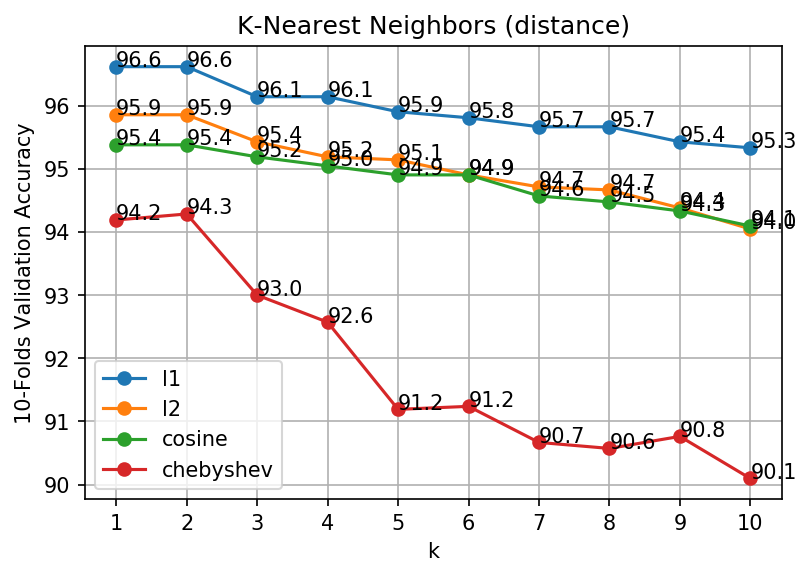

In [108]:
weights = ['uniform', 'distance']
metrics = ['l1', 'l2', 'cosine', 'chebyshev']

ENABLE_Z_SCORE = True
ENABLE_PCA = False
PCA_DIMS = 12
MAX_K = 10

for weight in weights:

    plt.figure(dpi=150)
    
    for metric in metrics:
                
        px = [x for x in range(1, MAX_K+1)]
        py = np.zeros((len(px),))
            
        for train_index, test_index in kf.split(X):
            X_train, X_test = X[train_index].copy(), X[test_index].copy()
            y_train, y_test = y[train_index].copy(), y[test_index].copy()
            
            if ENABLE_Z_SCORE:
                
                m = np.zeros_like(X_train)
                m[:, 2] = 1
                m = m.astype(np.bool)
                Xm_train = np.ma.array(X_train, mask=m)
                
                m = np.zeros_like(X_test)
                m[:, 2] = 1
                m = m.astype(np.bool)
                Xm_test = np.ma.array(X_test, mask=m)
                
                u = np.ma.mean(Xm_train, axis=0)
                o = np.ma.std(Xm_train, axis=0)
                
                Xm_train -= u
                Xm_train /- o
                
                Xm_test -= u
                Xm_test /- o
                
            if ENABLE_PCA:
                pca = PCA(n_components=PCA_DIMS)
                pca.fit(X_train)
                X_train = pca.transform(X_train)
                X_test = pca.transform(X_test)
            
            for k in range(1, MAX_K+1):
                neigh = KNeighborsClassifier(n_neighbors=k, metric=metric, weights=weight)
                neigh.fit(X_train, y_train)
                score = neigh.score(X_test, y_test)
                
                py[k-1] += score
                
        py = 100*py / 10 
                
        plt.plot(px, py, 'o-')
   
        for i in range(0, len(px)):
            plt.annotate("%.1f" % py[i], [px[i], py[i]])

    plt.grid()
    plt.ylabel('%d-Folds Validation Accuracy' % MAX_K)
    plt.xlabel('k')
    plt.xticks(px)
    plt.title('K-Nearest Neighbors (%s)' % weight)
    plt.legend(metrics)
    plt.show()